# Modeling with StatsModels

## 1. Ordinary Least Square
- Column Names
- Log Transformation
- Condition Number
- Standard Scaling

# 2. Dimensionality Reduction
- ANOVA
- F-test and Feature Influence

# 3. Outlier
- Cook's Distance

# 4. Regularization
- Lasso

# 5. Diagnosis of Regression
- Residual Normality Test
- Partial Regression Plot

# 6. Cross Validatoin

# 7. Test
- score

In [1]:
%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import warnings
import sys
import datetime
import scipy as sp
import statsmodels.stats.api as sms
import statsmodels.api as sm
from patsy import dmatrix
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import utils.statsmodel_helper as sh
import utils.feature_selection as fs
import utils.preprocessing as pp
import utils.error_calculator as ec

class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

df_train_macro = pd.read_csv('./data/train_macro.csv', index_col=0, parse_dates=['timestamp'])
df_test_macro = pd.read_csv('./data/test_macro.csv', index_col=0, parse_dates=['timestamp'])

sys.setrecursionlimit(1500)

degree = 2
skewness_limit = 1
num_of_cooks = 2
num_of_f_test = 10

ValueError: 'timestamp' is not in list

# 1. Column Names
## Column Names
Replace -, +, :, ~, * in column name with underscore

In [2]:
new_cols = []
for col in  list(df_train_macro.columns):
    col = col.replace('-', '_').replace('+', '_').replace(':', '_').replace('~', '_').replace('*', '_')
    new_cols.append('_'+col)
df_train_macro.columns = new_cols

new_cols = []
for col in list(df_test_macro.columns):
    col = col.replace('-', '_').replace('+', '_').replace(':', '_').replace('~', '_').replace('*', '_')
    new_cols.append('_'+col)
df_test_macro.columns = new_cols

categorial_ivs = list(set(df_train_macro.columns.drop('_timestamp')) - set(df_train_macro._get_numeric_data().columns))
numeric_ivs = df_train_macro._get_numeric_data().columns.drop('_price_doc').tolist()

## Log Transformation
Transform data with skewness greater than 1.

In [3]:
features_to_log = []
for f in df_train_macro._get_numeric_data().columns:
    skewness = sp.stats.skew(df_train_macro[f])
    if skewness > skewness_limit:
        features_to_log.append(f)

for col in df_train_macro._get_numeric_data().columns:
    if col != '_price_doc':
        min_val_train = min(df_train_macro[col])
        min_val_test  = min(df_test_macro[col])
        min_val = min(min_val_train, min_val_test)
        if min_val <= 0:
            df_train_macro[col] += (np.abs(min_val) + 0.1)
            df_test_macro[col]  += (np.abs(min_val) + 0.1)
    else:
        min_val_train = min(df_train_macro[col])
        if min_val_train <= 0:
            df_train_macro[col] += (np.abs(min_val_train) + 0.1)

In [4]:
formula = sh.make_statsmodels_ols_formula(numeric_ivs, categorial_ivs, '_price_doc', log_vs=features_to_log, degree=degree, scale=False)
model = sm.OLS.from_formula(formula, data=df_train_macro)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     165.4
Date:                Fri, 25 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:39:49   Log-Likelihood:                -21116.
No. Observations:               30471   AIC:                         4.244e+04
Df Residuals:                   30367   BIC:                         4.331e+04
Df Model:                         103                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================
                                                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                 14.7666      1.666      8.862      0.000      11.500      18.033
C(_detention_facility_raion)[T.yes]                       -0.0185      0.013     -1.476      0.140      -0.043       0.006
C(_oil_chemistry_raion)[T.yes]                            -0.0809      0.034     -2.367      0.018      -0.148      -0.014
C(_railroad_terminal_raion)[T.yes]                         0.0090      0.028      0.321      0.748      -0.046       0.064
C(_radiation_raion)[T.yes]                                -0.0536      0.009     -6.224      0.000      -0.070      -0.037
C(_nuclear_reactor_raion)[T.yes]                          -0.0240      0.020     -1.209      0.227      -0.063       0.015
C(_thermal_power_plant_raion)[T.yes]                       0.0055      0.016      0.335      0.738      -0.027       0.038
C(_incineration_raion)[T.yes]                              0.0262      0.022      1.208      0.227      -0.016       0.069
C(_railroad_1line)[T.yes]                                 -0.1838      0.018    -10.108      0.000      -0.219      -0.148
C(_product_type)[T.OwnerOccupier]                          0.1249      0.010     12.020      0.000       0.105       0.145
C(_big_road1_1line)[T.yes]                                -0.0163      0.020     -0.829      0.407      -0.055       0.022
C(_big_market_raion)[T.yes]                                0.0026      0.015      0.169      0.866      -0.028       0.033
C(_water_1line)[T.yes]                                     0.0015      0.012      0.128      0.898      -0.022       0.025
C(_culture_objects_top_25)[T.yes]                          0.0700      0.018      3.920      0.000       0.035       0.105
C(_ecology)[T.good]                                       -0.0430      0.015     -2.798      0.005      -0.073      -0.013
C(_ecology)[T.no data]                                    -0.1889      0.027     -7.028      0.000      -0.242      -0.136
C(_ecology)[T.poor]                                       -0.0021      0.013     -0.157      0.875      -0.028       0.024
C(_ecology)[T.satisfactory]                                0.0395      0.017      2.307      0.021       0.006       0.073
np.log(_full_sq)                                          -0.4696      0.040    -11.743      0.000      -0.548      -0.391
np.log(_life_sq)                                           0.1104      0.028      4.000      0.000       0.056       0.164
np.log(_floor)                                             0.1197      0.014      8.863      0.000       0.093       0.146
np.log(_num_room)                                         -0.0349      0.017     -2.042      0.041      -0.068      -0.001
np.log(_

## Condition Number
Large condition number occurs when the scale of data changes significantly due to the unit difference. Scaling can decrease condition number. Multicollinearity can also cause large condition number. We can handle this by reducing dimensionality with variance inflation factor.

## Standard Scaling
Standalize variables by removing the mean and scaling to unit variance.

In [5]:
formula = sh.make_statsmodels_ols_formula(numeric_ivs, categorial_ivs, '_price_doc', log_vs=features_to_log, degree=degree, scale=True)
model = sm.OLS.from_formula(formula, data=df_train_macro)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     165.4
Date:                Fri, 25 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:40:18   Log-Likelihood:                -21116.
No. Observations:               30471   AIC:                         4.244e+04
Df Residuals:                   30367   BIC:                         4.331e+04
Df Model:                         103                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        15.6385      0.016   1000.747      0.000      15.608      15.669
C(_detention_facility_raion)[T.yes]                              -0.0185      0.013     -1.476      0.140      -0.043       0.006
C(_oil_chemistry_raion)[T.yes]                                   -0.0809      0.034     -2.367      0.018      -0.148      -0.014
C(_railroad_terminal_raion)[T.yes]                                0.0090      0.028      0.321      0.748      -0.046       0.064
C(_radiation_raion)[T.yes]                                       -0.0536      0.009     -6.224      0.000      -0.070      -0.037
C(_nuclear_reactor_raion)[T.yes]                                 -0.0240      0.020     -1.209      0.227      -0.063       0.015
C(_thermal_power_plant_raion)[T.yes]                              0.0055      0.016      0.335      0.738      -0.027       0.038
C(_incineration_raion)[T.yes]                                     0.0262      0.022      1.208      0.227      -0.016       0.069
C(_railroad_1line)[T.yes]                                        -0.1838      0.018    -10.108      0.000      -0.219      -0.148
C(_product_type)[T.OwnerOccupier]                                 0.1249      0.010     12.020      0.000       0.105       0.145
C(_big_road1_1line)[T.yes]                                       -0.0163      0.020     -0.829      0.407      -0.055       0.022
C(_big_market_raion)[T.yes]                                       0.0026      0.015      0.169      0.866      -0.028       0.033
C(_water_1line)[T.yes]                                            0.0015      0.012      0.128      0.898      -0.022       0.025
C(_culture_objects_top_25)[T.yes]                                 0.0700      0.018      3.920      0.000       0.035       0.105
C(_ecology)[T.good]                                              -0.0430      0.015     -2.798      0.005      -0.073      -0.013
C(_ecology)[T.no data]                                           -0.1889      0.027     -7.028      0.000      -0.242      -0.136
C(_ecology)[T.poor]                                              -0.0021      0.013     -0.157      0.875      -0.028       0.024
C(_ecology)[T.satisfactory]                                       0.0395      0.017      2.307      0.021       0.006       0.073
scale(np.log(_full_sq))                                          -0.1738      0.015    -11.743      0.000      -0.203      -0.145
scale(np.log(_life_sq))                                           0.0682      0.017      4.000      0.000       0.035       0.102
scale(np.log(_floor))                                             0.0937      0.011      8.86

Scaling did not significantly decrease the condition number.

# 2. Dimensionality Reduction
## ANOVA

In [6]:
anova = sm.stats.anova_lm(result, typ=2)
anova

,sum_sq,df,F,PR(>F)
C(_detention_facility_raion),0.511675,1.0,2.177983,1.400082e-01
C(_oil_chemistry_raion),1.316679,1.0,5.604542,1.792021e-02
C(_railroad_terminal_raion),0.024197,1.0,0.102995,7.482673e-01
C(_radiation_raion),9.102063,1.0,38.743593,4.896069e-10
C(_nuclear_reactor_raion),0.343129,1.0,1.460553,2.268515e-01
C(_thermal_power_plant_raion),0.026336,1.0,0.112100,7.377686e-01
C(_incineration_raion),0.343031,1.0,1.460136,2.269178e-01
C(_railroad_1line),24.002180,1.0,102.167031,5.569381e-24
C(_product_type),33.943459,1.0,144.482811,3.314829e-33
C(_big_road1_1line),0.161423,1.0,0.687109,4.071560e-01



We can remove features with p-value equal or greater than 0.05 since they have very small influences on the dependent variable

## F-test and Feature Influence

In [7]:
result, sms_vars, formula = fs.by_f_test(df_train_macro, formula, repeat=num_of_f_test)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     291.5
Date:                Fri, 25 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:43:13   Log-Likelihood:                -21167.
No. Observations:               30471   AIC:                         4.245e+04
Df Residuals:                   30412   BIC:                         4.294e+04
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        15.6578      0.011   1442.183      0.000      15.636      15.679
C(_oil_chemistry_raion)[T.yes]                                   -0.0786      0.030     -2.659      0.008      -0.137      -0.021
C(_radiation_raion)[T.yes]                                       -0.0510      0.008     -6.421      0.000      -0.067      -0.035
C(_railroad_1line)[T.yes]                                        -0.1809      0.017    -10.385      0.000      -0.215      -0.147
C(_product_type)[T.OwnerOccupier]                                 0.1282      0.010     13.210      0.000       0.109       0.147
C(_culture_objects_top_25)[T.yes]                                 0.0679      0.016      4.224      0.000       0.036       0.099
C(_ecology)[T.good]                                              -0.0629      0.012     -5.098      0.000      -0.087      -0.039
C(_ecology)[T.no data]                                           -0.2288      0.016    -14.306      0.000      -0.260      -0.197
C(_ecology)[T.poor]                                              -0.0145      0.011     -1.305      0.192      -0.036       0.007
C(_ecology)[T.satisfactory]                                       0.0117      0.014      0.819      0.413      -0.016       0.040
scale(np.log(_full_sq))                                          -0.1721      0.015    -11.630      0.000      -0.201      -0.143
scale(np.log(_life_sq))                                           0.0704      0.017      4.131      0.000       0.037       0.104
scale(np.log(_floor))                                             0.0940      0.011      8.917      0.000       0.073       0.115
scale(np.log(_num_room))                                         -0.0126      0.006     -2.033      0.042      -0.025      -0.000
scale(np.log(_state))                                            -0.0910      0.008    -10.811      0.000      -0.107      -0.074
scale(np.log(_school_education_centers_top_20_raion))             0.2145      0.031      6.902      0.000       0.154       0.275
scale(np.log(_hospital_beds_raion))                              -0.0573      0.020     -2.811      0.005      -0.097      -0.017
scale(np.log(_healthcare_centers_raion))                          0.0280      0.004      6.583      0.000       0.020       0.036
scale(np.log(_public_transport_station_min_walk))                -0.0160      0.005     -2.983      0.003      -0.026      -0.005
scale(_big_road2_km)                                             -0.0226      0.004     -5.894      0.000      -0.030      -0.015
scale(np.log(_market_shop_km))                                   -0.0192      0.005     -4.10

# 3. Outlier
## Cook's Distance
- Find data with large leverage and residual by calculating Cook's distance.

In [8]:
df_train_macro_with_outliers = df_train_macro.copy(deep=True)
df_train_macro, model, result = pp.remove_outliers(df_train_macro, formula, repeat=5)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     3493.
Date:                Fri, 25 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:44:23   Log-Likelihood:                 16109.
No. Observations:               23830   AIC:                        -3.210e+04
Df Residuals:                   23771   BIC:                        -3.162e+04
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        15.8030      0.003   4789.979      0.000      15.797      15.810
C(_oil_chemistry_raion)[T.yes]                                   -0.0631      0.009     -7.324      0.000      -0.080      -0.046
C(_radiation_raion)[T.yes]                                       -0.0242      0.002    -10.207      0.000      -0.029      -0.020
C(_railroad_1line)[T.yes]                                        -0.2093      0.006    -34.616      0.000      -0.221      -0.197
C(_product_type)[T.OwnerOccupier]                                -0.1304      0.003    -42.418      0.000      -0.136      -0.124
C(_culture_objects_top_25)[T.yes]                                 0.1197      0.005     22.499      0.000       0.109       0.130
C(_ecology)[T.good]                                              -0.0151      0.004     -4.144      0.000      -0.022      -0.008
C(_ecology)[T.no data]                                           -0.1857      0.005    -39.194      0.000      -0.195      -0.176
C(_ecology)[T.poor]                                               0.0221      0.003      6.640      0.000       0.016       0.029
C(_ecology)[T.satisfactory]                                       0.0554      0.004     12.894      0.000       0.047       0.064
scale(np.log(_full_sq))                                           0.1213      0.017      7.178      0.000       0.088       0.154
scale(np.log(_life_sq))                                           0.0112      0.009      1.213      0.225      -0.007       0.029
scale(np.log(_floor))                                             0.0756      0.003     22.995      0.000       0.069       0.082
scale(np.log(_num_room))                                         -0.0412      0.003    -13.606      0.000      -0.047      -0.035
scale(np.log(_state))                                            -0.0732      0.003    -28.777      0.000      -0.078      -0.068
scale(np.log(_school_education_centers_top_20_raion))             0.1641      0.011     15.355      0.000       0.143       0.185
scale(np.log(_hospital_beds_raion))                              -0.0338      0.006     -5.338      0.000      -0.046      -0.021
scale(np.log(_healthcare_centers_raion))                          0.0237      0.001     18.433      0.000       0.021       0.026
scale(np.log(_public_transport_station_min_walk))                 0.0081      0.002      4.926      0.000       0.005       0.011
scale(_big_road2_km)                                             -0.0197      0.001    -17.575      0.000      -0.022      -0.018
scale(np.log(_market_shop_km))                                   -0.0088      0.001     -6.30

# 4. Regularization
## Lasso
Find variables with zero coefficient when Lasso regularization is applied.

In [9]:
result_lasso = model.fit_regularized(alpha=0.001, L1_wt=1)

Let's remove features with zero coefficient to reduce dimensionality.

In [10]:
sms_vars = []
for idx, coef in enumerate(result_lasso.params):
    if coef ==0:
        continue
    feature = result_lasso.params.index[idx]
    if feature == 'Intercept':
        continue
    startDelPos = feature.find('[')
    endDelPos = feature.find(']')
    feature = feature.replace(feature[startDelPos:endDelPos+1], '')
    sms_vars.append(feature)

In [11]:
formula = 'np.log(_price_doc) ~ ' + " + ".join(sms_vars)
model = sm.OLS.from_formula(formula, data=df_train_macro)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     4855.
Date:                Fri, 25 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:44:35   Log-Likelihood:                 16325.
No. Observations:               22999   AIC:                        -3.256e+04
Df Residuals:                   22956   BIC:                        -3.222e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                            15.7883      0.003   5149.028      0.000      15.782      15.794
C(_railroad_1line)[T.yes]                            -0.2277      0.006    -36.585      0.000      -0.240      -0.216
C(_product_type)[T.OwnerOccupier]                    -0.1344      0.003    -45.309      0.000      -0.140      -0.129
C(_culture_objects_top_25)[T.yes]                     0.1317      0.005     24.937      0.000       0.121       0.142
C(_ecology)[T.good]                                  -0.0201      0.004     -5.708      0.000      -0.027      -0.013
C(_ecology)[T.no data]                               -0.1677      0.004    -39.705      0.000      -0.176      -0.159
C(_ecology)[T.poor]                                   0.0184      0.003      5.680      0.000       0.012       0.025
C(_ecology)[T.satisfactory]                           0.0416      0.004     10.195      0.000       0.034       0.050
scale(np.log(_full_sq))                               0.1135      0.016      7.104      0.000       0.082       0.145
scale(np.log(_floor))                                 0.0760      0.003     23.493      0.000       0.070       0.082
scale(np.log(_num_room))                             -0.0419      0.003    -14.219      0.000      -0.048      -0.036
scale(np.log(_state))                                -0.0724      0.002    -29.062      0.000      -0.077      -0.067
scale(np.log(_hospital_beds_raion))                   0.0021      0.001      2.314      0.021       0.000       0.004
scale(np.log(_healthcare_centers_raion))              0.0207      0.001     17.931      0.000       0.018       0.023
scale(_big_road2_km)                                 -0.0216      0.001    -20.285      0.000      -0.024      -0.020
scale(np.log(_market_shop_km))                       -0.0093      0.001     -8.442      0.000      -0.012      -0.007
scale(np.log(_fitness_km))                           -0.0281      0.001    -22.020      0.000      -0.031      -0.026
scale(np.log(_church_synagogue_km))                  -0.0097      0.001     -9.889      0.000      -0.012      -0.008
scale(np.log(_catering_km))                          -0.0783      0.002    -42.190      0.000      -0.082      -0.075
scale(np.log(_cafe_count_500_price_1500))            -0.0276      0.002    -11.063      0.000      -0.032      -0.023
scale(np.log(_cafe_count_1000_price_high))           -0.0267      0.002    -17.262      0.000      -0.030      -0.024
scale(np.log(_mosque_count_1500))                     0.0163      0.001     14.001      0.000       0.014       0.019
scale(np.log(_mosque_count_2000))                    -0.0175      0.001    -12.587      0.000      -0.020      -0.015
scale(np.log(_m

# 5. Diagnosis of Regression
## Residual Normality Test

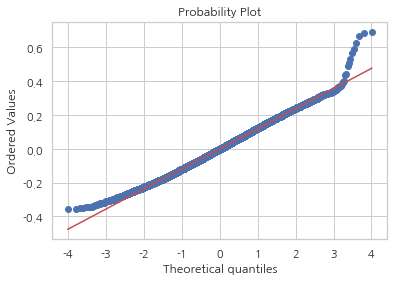

In [12]:
# outlier remove result 
sp.stats.probplot(result.resid, plot=plt)
plt.show()

In [13]:
test = sms.omni_normtest(result.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       : 67.170
P-value     :  0.000


# Partial Regression Plot
Let's visualize the influence of a single independent variable.

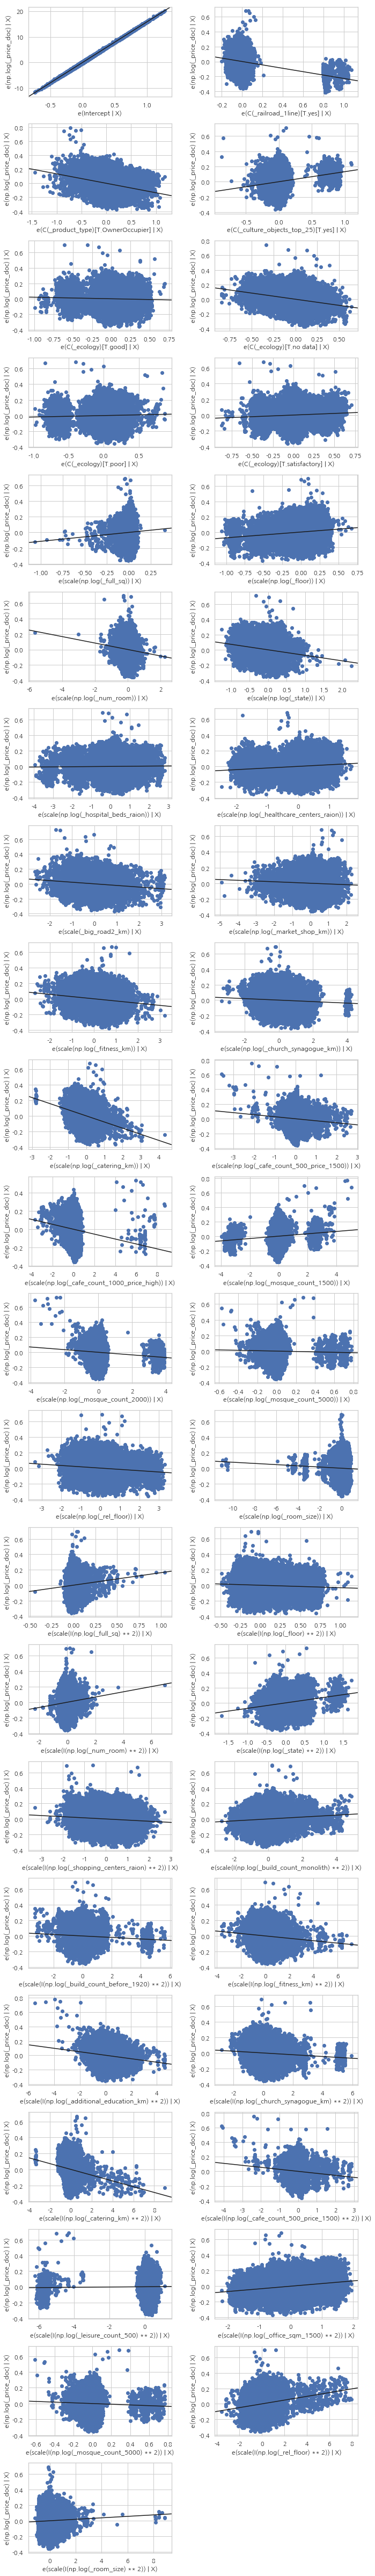

In [14]:
fig = plt.figure(figsize=(10,70))
sm.graphics.plot_partregress_grid(result, fig=fig)
fig.suptitle("")
plt.show()

# 6. Cross Validation

In [15]:
dm = dmatrix(" + ".join(sms_vars) + ' + np.log(_price_doc)', df_train_macro_with_outliers, return_type="dataframe")
X = dm[dm.columns.drop(['np.log(_price_doc)'])]
y = dm['np.log(_price_doc)']
cv = cv = KFold(n_splits=1000, shuffle=True, random_state=0)
r2s = cross_val_score(SMWrapper(sm.OLS), X, y, scoring='r2', cv=cv)
r2s.mean()

0.3382942848693803

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   1.,   2.,   0.,   2.,   2.,   3.,   5.,  10.,  13.,
         14.,  38.,  55.,  84., 114., 141., 148., 152., 103.,  66.,  34.,
         11.]),
 array([-6.77254801, -6.69664865, -6.62074929, -6.54484992, -6.46895056,
        -6.39305119, -6.31715183, -6.24125246, -6.1653531 , -6.08945374,
        -6.01355437, -5.93765501, -5.86175564, -5.78585628, -5.70995692,
        -5.63405755, -5.55815819, -5.48225882, -5.40635946, -5.33046009,
        -5.25456073, -5.17

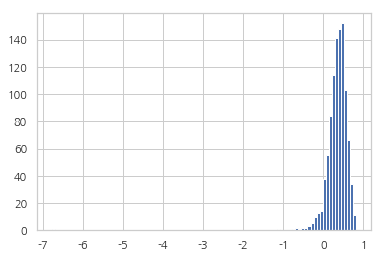

In [16]:
plt.hist(r2s, bins=100)

In [17]:
y_pred = np.exp(result.predict(df_test_macro))
y_pred = y_pred.to_frame('price_doc')
y_pred.to_csv('./data/stats_models_{}.csv'.format(datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')), header=True, index=True)